# 4.5.1 Unsupervised Learning Capstone
For this project you'll dig into a large amount of text and apply most of what you've covered in this unit and in the course so far.

First, pick a set of texts. This can be either a series of novels, chapters, or articles. Anything you'd like. It just has to have multiple entries of varying characteristics. At least 100 should be good. There should also be at least 10 different authors, but try to keep the texts related (either all on the same topic of from the same branch of literature - something to make classification a bit more difficult than obviously different subjects).

This capstone can be an extension of your NLP challenge if you wish to use the same corpus. If you found problems with that data set that limited your analysis, however, it may be worth using what you learned to choose a new corpus. Reserve 25% of your corpus as a test set.

The first technique is to create a series of clusters. Try several techniques and pick the one you think best represents your data. Make sure there is a narrative and reasoning around why you have chosen the given clusters. Are authors consistently grouped into the same cluster?

Next, perform some unsupervised feature generation and selection using the techniques covered in this unit and elsewhere in the course. Using those features then build models to attempt to classify your texts by author. Try different permutations of unsupervised and supervised techniques to see which combinations have the best performance.

Lastly return to your holdout group. Does your clustering on those members perform as you'd expect? Have your clusters remained stable or changed dramatically? What about your model? Is it's performance consistent?

If there is a divergence in the relative stability of your model and your clusters, delve into why.

Your end result should be a write up of how clustering and modeling compare for classifying your texts. What are the advantages of each? Why would you want to use one over the other? Approximately 3-5 pages is a good length for your write up, and remember to include visuals to help tell your story!

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import re
import spacy
from collections import Counter
import sklearn
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Objective

The goal of this project is to train a model with texts from different authors, and determine the accuracy of the model when predicting from which author a new text belongs. 

## Text Selection and Cleaning

I selected 10 literary works from these 12 different authors:

- emerson
- shakespeare
- hawthorne
- kant
- poe
- burroughs
- doyle
- plato
- dickens
- aristotle
- jefferson
- irving 

I downloaded the .txt files from:

http://www.textfiles.com/etext/AUTHORS/

And manually cleaned the metadata from each text. Running the scripts below with their complete work required too much memory that my computer couldn't handle, so I manually cutted off from each file a part of the texts randomnly, and used this to persue my goal.

## Loading the files

In [2]:
#Each file is named "author-work.txt"

filenames = os.listdir('../Unsupervised capstone/books/') 
authors = list(set([filename.split('-')[0] for filename in filenames]))

In [3]:
authors

['doyle',
 'poe',
 'emerson',
 'shakespeare',
 'dickens',
 'hawthorne',
 'aristotle',
 'burroughs',
 'jefferson',
 'irving',
 'plato',
 'kant']

In [4]:
df = pd.DataFrame(columns = ['author', 'title', 'filename'])

df['filename'] = filenames
df['author'] = [file.split('-')[0] for file in df['filename']]
df['title'] = [file.split('-')[1].split('.txt')[0] for file in df['filename']]
df.head()

,author,title,filename
0,plato,cratylus,plato-cratylus-338.txt
1,kant,science,kant-science-146.txt
2,jefferson,public,jefferson-public-259.txt
3,plato,critias,plato-critias-339.txt
4,irving,broken,irving-broken-571.txt


In [5]:
df['full_text'] = None
texts = []
bad_file_count = 0
for i, filename in enumerate(filenames):
    try:
        with open(r'../Unsupervised capstone/books/'+filename, encoding='utf-8') as file:
            data = file.read()
            df.loc[i, 'full_text'] = data
            texts.append(data)
    except:
        bad_file_count += 1

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)
print('Number of bad files encountered:', bad_file_count)
df.head()

Number of bad files encountered: 0


,author,title,filename,full_text
0,plato,cratylus,plato-cratylus-338.txt,"Her. I should explain to you, Socrates, that..."
1,kant,science,kant-science-146.txt,\n This question may be said to be about as e...
2,jefferson,public,jefferson-public-259.txt,\n THAT _it is the opinion of this Comm...
3,plato,critias,plato-critias-339.txt,"Timaeus. How thankful I am, Socrates, that I h..."
4,irving,broken,irving-broken-571.txt,\n IT IS a common practice with those who hav...


In [6]:
df['full_text']

0        Her. I should explain to you, Socrates, that...
1      \n  This question may be said to be about as e...
2      \n        THAT _it is the opinion of this Comm...
3      Timaeus. How thankful I am, Socrates, that I h...
4      \n  IT IS a common practice with those who hav...
5                            \n                      ...
6      \n\n  Soc. He whom you mean, Crito, is Euthyde...
7      \n  MISERY is manifold. The wretchedness of ea...
8      \n\n  Soc. I often envy the profession of a rh...
9      \n"Magnifique!" ejaculated the Countess de Cou...
10     \n        Resolved, that it be an instruction ...
11     \n  The dinner was served up in the great hall...
12                                                   ...
13     \n\n  Charmides, he replied, is his name; he i...
14              \n                                 1\...
15     \n        BROTHER JOHN BAPTIST DE COIGNE, -- I...
16     \n  There are not many people -- and as it is ...
17     \n\n        Limits\n    

In [7]:
def text_cleaner(text):
    text = re.sub(r'--', ' ', text)
    text = re.sub(r'\d', '', text)
    #text = re.sub(r'\.', ' ', text)
    text = re.sub(r'\,', '', text)
    text = re.sub(r'\_', '', text)
    text = re.sub(r'\"', '', text)
    text = re.sub(r'\!', '', text)
    text = re.sub(r'\?', '', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text

In [8]:
# Clean all lead paragraphs
df['full_text'] = df.full_text.map(lambda x: text_cleaner(str(x)))
display(df.head())
print('Dataframe shape: ', df.shape)

,author,title,filename,full_text
0,plato,cratylus,plato-cratylus-338.txt,her. i should explain to you socrates that our...
1,kant,science,kant-science-146.txt,this question may be said to be about as embar...
2,jefferson,public,jefferson-public-259.txt,that it is the opinion of this committee that ...
3,plato,critias,plato-critias-339.txt,timaeus. how thankful i am socrates that i hav...
4,irving,broken,irving-broken-571.txt,it is a common practice with those who have ou...


Dataframe shape:  (102, 4)


In [9]:
df['full_text']


0      her. i should explain to you socrates that our...
1      this question may be said to be about as embar...
2      that it is the opinion of this committee that ...
3      timaeus. how thankful i am socrates that i hav...
4      it is a common practice with those who have ou...
5      every art and every inquiry and similarly ever...
6      soc. he whom you mean crito is euthydemus; and...
7      misery is manifold. the wretchedness of earth ...
8      soc. i often envy the profession of a rhapsode...
9      magnifique ejaculated the countess de coude be...
10     resolved that it be an instruction to the said...
11     the dinner was served up in the great hall whe...
12     our next task is to study coming-to-be and pas...
13     charmides he replied is his name; he is my cou...
14     we must in the next place investigate the subj...
15     brother john baptist de coigne i am very much ...
16     there are not many people and as it is desirab...
17     limits virginia is bound

## Input, Output & Holdout

Splitting into training and testing sets:

In [10]:
# Identifying variables
X = df['full_text']
y = df['author']

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Feature Generation 
### Tf-idf Vectorization
To obtain better cluster results we will vectorize the words in our texts.  Term Frequency Inverse Document Frequency (Tf-idf) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.  The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=4,
                            stop_words='english',
                            lowercase=False,
                            use_idf=True,
                            norm=u'l2')
# Applying the vectorizer
X_tfidf = vectorizer.fit_transform(X)
print('Number of features: {}'.format(X_tfidf.get_shape()[1]))

# Splitting into train and test sets
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.25, random_state=42)

# Reshape vectorizer to readable content
X_train_tfidf_csr = X_train_tfidf.tocsr()

# Number of paragraphs
n = X_train_tfidf_csr.shape[0]

# A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]

# List of features
terms = vectorizer.get_feature_names()

# For each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

# Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[2])
print('Tf_idf vector:', tfidf_bypara[0])
    

Number of features: 882
Original sentence: that it is the opinion of this committee that when the general council and assembly or general court of any of his majesty's provinces or colonies in america shall propose to make provision according to the condition circumstance or situation of such province or colony for contributing their proportion to the common defence (such proportion to be raised under the authority of the general court or general assembly of such province or colony and disposable by parliament) and shall engage to make provision also for the support of the civil government and the administration of justice in such province or colony it will be proper if such proposal shall be approved by his majesty and the two houses of parliament; and for so long as such provision shall be made accordingly to forbear in respect of such province or colony to lay any duty tax or assessment or to impose any further duty tax or assessment except only such duties as it may be expedient to

We will now normalize our data to best cluster data:

In [12]:
from sklearn.preprocessing import normalize
X_norm = normalize(X_train_tfidf)

### Natural Language Processing - spaCy
We will tokenize each sentence to be able to extract information and add as features in our models.

In [13]:
# Instantiating spaCy
nlp = spacy.load('en')
X_train_words = []

for row in X_train:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_train_words.append([row_doc, advs, verb, noun, adj, sent_len])

In [14]:
y_train_new = y_train.reset_index(drop=True)

Joining the new features and the author names:

In [15]:
# Data frame for features
txt_bow = pd.DataFrame(data=X_train_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Adding author data
txt_bow = pd.concat([txt_bow, y_train_new], ignore_index=False, axis=1)
txt_bow.head()

,BOW,ADV,VERB,NOUN,ADJ,sent_length,author
0,"(brother, john, baptist, de, coigne, i, am, ve...",53,184,125,82,845,jefferson
1,"(once, upon, a, time, of, all, the, good, days...",22,54,62,37,296,dickens
2,"(soc, ., very, good, callicles, ;, but, will, ...",19,69,49,17,275,plato
3,"(magnifique, ejaculated, the, countess, de, co...",27,49,51,37,263,burroughs
4,"(the, entire, affair, is, shrouded, in, myster...",24,71,88,43,392,burroughs


In [16]:
X_norm_df = pd.DataFrame(data=X_norm.toarray())
txt_tfidf_bow = pd.concat([txt_bow, X_norm_df], ignore_index=False, axis=1)
txt_tfidf_bow.head()

,BOW,ADV,VERB,NOUN,ADJ,sent_length,author,0,1,2,...,872,873,874,875,876,877,878,879,880,881
0,"(brother, john, baptist, de, coigne, i, am, ve...",53,184,125,82,845,jefferson,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.037030,0.000000,0.0,0.000000,0.039043,0.0
1,"(once, upon, a, time, of, all, the, good, days...",22,54,62,37,296,dickens,0.0,0.0,0.0,...,0.0,0.0,0.0,0.118679,0.000000,0.000000,0.0,0.000000,0.000000,0.0
2,"(soc, ., very, good, callicles, ;, but, will, ...",19,69,49,17,275,plato,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.072124,0.104377,0.0,0.000000,0.000000,0.0
3,"(magnifique, ejaculated, the, countess, de, co...",27,49,51,37,263,burroughs,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.287463,0.290630,0.0
4,"(the, entire, affair, is, shrouded, in, myster...",24,71,88,43,392,burroughs,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [17]:
print('Final training dataframe shape:', txt_tfidf_bow.shape)

Final training dataframe shape: (76, 889)


### Feature Selection
Using SelectKBest, we selected the best 150 features:

In [18]:
# Identifying features and labels to choose from
features = txt_tfidf_bow.drop(['BOW', 'author'], axis=1)
y2_train = txt_tfidf_bow.author

In [19]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Instantiating and fitting the 150 best features
kbest = SelectKBest(chi2, k=150)
X2_train = kbest.fit_transform(features, y2_train)

## Clustering

### K-Means Clustering
K-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells (Wikipedia info).

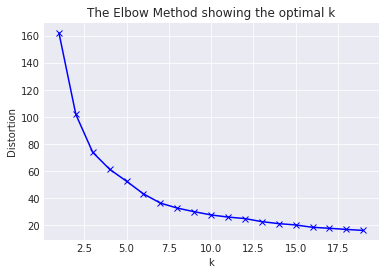

In [20]:
from sklearn.cluster import KMeans
from  scipy.spatial.distance  import cdist
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X2_train)
    kmeanModel.fit(X2_train)
    distortions.append(sum(np.min(cdist(X2_train, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X2_train.shape[0])

# Plot the elbow
sns.set_style('darkgrid')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [21]:
# Calulate predicted values
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=20)
y_pred = kmeans.fit_predict(X2_train)

pd.crosstab(y2_train, y_pred)

col_0,0,1,2,3,4
author,,,,,
aristotle,2,1,2,0,2
burroughs,7,0,2,0,0
dickens,3,0,2,0,1
doyle,3,0,3,0,1
emerson,2,0,5,0,0
hawthorne,6,0,2,0,0
irving,2,0,4,0,0
jefferson,2,0,2,0,1
kant,3,1,1,0,0


To make it easier to visualize our potential clusters, we will reduce the data to 2 components using PCA.

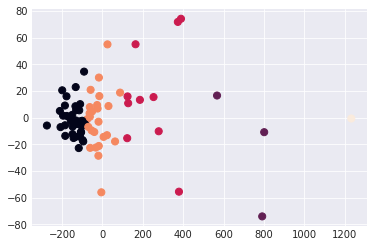

In [22]:
from sklearn.decomposition import PCA

# Reduce it to two components.
X_pca = PCA(2).fit_transform(X2_train)

# Calculate predicted values.
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, s=50)
plt.show()

In [23]:
from sklearn.metrics import silhouette_score

print('Silhouette Score: {:0.7}'.format(silhouette_score(X_pca, y_pred, metric='euclidean')))

Silhouette Score: 0.5006142


The silhouette score did much beter than what I expected.

### Mini Batch K Means

In [24]:
from sklearn.cluster import MiniBatchKMeans
minikmeans = MiniBatchKMeans(n_clusters=5, init='k-means++', random_state=42, init_size=1000, batch_size=1000)

y_pred2 = minikmeans.fit_predict(X_pca)

pd.crosstab(y2_train, y_pred2)

col_0,0,1,2,3,4
author,,,,,
aristotle,3,2,0,1,1
burroughs,0,4,0,5,0
dickens,1,2,0,3,0
doyle,0,1,0,3,3
emerson,0,6,0,0,1
hawthorne,0,5,0,2,1
irving,0,4,0,1,1
jefferson,1,2,0,2,0
kant,0,2,1,2,0


In [25]:
print('Silhouette Score: {:0.7}'.format(silhouette_score(X_pca, y_pred2, metric='euclidean')))

Silhouette Score: 0.4524854


It obtained a similar performance to the K-Means Clustering

### Spectral Clustering

In [26]:
from sklearn.cluster import SpectralClustering

n_clusters= 12
sc = SpectralClustering(n_clusters=n_clusters)
y_pred3 = sc.fit_predict(X_pca)

pd.crosstab(y2_train, y_pred3)

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


col_0,0,1,2,3,4,5,6,7,8,9,10,11
author,,,,,,,,,,,,
aristotle,6,0,1,0,0,0,0,0,0,0,0,0
burroughs,7,0,0,1,0,0,0,0,0,0,0,1
dickens,5,0,0,0,0,1,0,0,0,0,0,0
doyle,6,0,0,0,0,1,0,0,0,0,0,0
emerson,5,0,0,0,1,0,0,0,1,0,0,0
hawthorne,5,0,0,0,0,0,1,1,0,0,1,0
irving,5,0,0,0,1,0,0,0,0,0,0,0
jefferson,3,0,0,1,0,0,0,0,0,0,0,1
kant,3,1,0,0,0,0,0,0,0,0,1,0


In [27]:
print('Silhouette Score: {:0.7}'.format(silhouette_score(X_pca, y_pred3, metric='euclidean')))

Silhouette Score: -0.3757289


The model didn't perform correctly.

### Affinity Propagation

In [28]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(damping=0.5, max_iter=550, copy=False)
y_pred4 = af.fit_predict(X_pca)

cluster_centers_indices = af.cluster_centers_indices_
n_clusters = len(cluster_centers_indices)
print('Number of estimated clusters: {}'.format(n_clusters))

pd.crosstab(y2_train, y_pred4)

Number of estimated clusters: 10


col_0,0,1,2,3,4,5,6,7,8,9
author,,,,,,,,,,
aristotle,0,0,1,1,0,0,2,2,1,0
burroughs,3,0,0,0,3,0,0,3,0,0
dickens,1,0,0,1,2,0,1,1,0,0
doyle,1,0,2,1,3,0,0,0,0,0
emerson,2,0,0,3,0,0,0,2,0,0
hawthorne,1,0,0,1,0,0,0,6,0,0
irving,2,0,1,1,0,0,0,2,0,0
jefferson,1,1,0,1,1,0,0,1,0,0
kant,1,0,0,0,1,0,0,2,0,1


In [29]:
print('Silhouette Score: {:0.7}'.format(silhouette_score(X_pca, y_pred4, metric='euclidean')))

Silhouette Score: 0.4256587


Affinity Propagation, didn't perform very well, hence I will use the k-means clusters as additional features.

In [30]:
X2_train_c = pd.DataFrame(X_pca)
X2_train_c['kmeans_clust'] = y_pred

## Latent Semantic Analysis

We will now use LSA to optmize our script. LSA is a dimension reduction technique that run on the tf-idf matrix.

In [31]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 27911 to 10.
svd= TruncatedSVD(10)

# Train the data for features since there's non tf-idf data in the features section.
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(features)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 99.9987853173


## Sentence Similarity

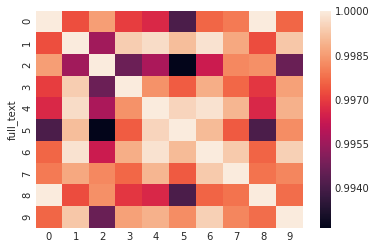

In [32]:
# Compute document similarity using LSA components
similarity = np.asarray(np.asmatrix(X_train_lsa) * np.asmatrix(X_train_lsa).T)
#Only taking the first 10 sentences
sim_matrix=pd.DataFrame(similarity,index=X_train).iloc[0:10,0:10]
#Making a plot
ax = sns.heatmap(sim_matrix,yticklabels=range(10))
plt.show()

# Classification Models 
Now, I will use supervised classification models with and without the k-means clustering predictions as features to see how well our model performs.  I will start with the default settings in the models to get a baseline score.
## Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rfc_c = RandomForestClassifier()
train_c = rfc_c.fit(X2_train_c, y2_train)
rfc_c_scores = cross_val_score(rfc_c, X2_train_c, y_train, cv=5)
print('Training set score with clustering: {:.5f}(+/- {:.3f})'.format(rfc_c_scores.mean(), rfc_c_scores.std()*2))

rfc = RandomForestClassifier()
train = rfc.fit(X2_train, y2_train)
rfc_scores = cross_val_score(rfc, X2_train, y_train, cv=5)
print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(rfc_scores.mean(), rfc_scores.std()*2))

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training set score with clustering: 0.17054(+/- 0.148)

Training set score without clustering:0.33233(+/- 0.269)


Using the training set with the clustering feature, performed better than without it.

## Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression

lr_c = LogisticRegression()
train_c = lr_c.fit(X2_train_c, y2_train)
lr_c_scores = cross_val_score(lr_c, X2_train_c, y_train, cv=5)
print('Training set score with clustering: {:.5f}(+/- {:.3f})'.format(lr_c_scores.mean(), lr_c_scores.std()*2))

lr = LogisticRegression()
train = lr.fit(X2_train, y2_train)
lr_scores = cross_val_score(lr, X2_train, y_train, cv=5)
print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(lr_scores.mean(), lr_scores.std()*2))

Training set score with clustering: 0.20872(+/- 0.089)

Training set score without clustering:0.29114(+/- 0.243)


/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


In the case of Logistic Regression, using the clustering features wasn't a good idea. However, the performance is not good in both scenarios.

## Gradient Boosting

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

clf_c = GradientBoostingClassifier()
train_c = clf_c.fit(X2_train_c, y2_train)
clf_c_scores = cross_val_score(clf_c, X2_train_c, y_train, cv=5)
print('Training set score with clustering: {:.5f}(+/- {:.3f})'.format(clf_c_scores.mean(), clf_c_scores.std()*2))

clf = GradientBoostingClassifier()
train = clf.fit(X2_train, y2_train)
clf_scores = cross_val_score(clf, X2_train, y_train, cv=5)
print('\nTraining set score without clustering:{:.5f}(+/- {:.3f})'.format(clf_scores.mean(), clf_scores.std()*2))

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Training set score with clustering: 0.12730(+/- 0.208)


/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)



Training set score without clustering:0.44971(+/- 0.259)


Using the Gradient Boost Classifier (GBC), the performance was better without the clustering features, and the score was even better than the one obtained from the Random Forest Classifier. I will use GridSearchCV to obtain the best parameters, and try to improve GBC's accuracy.

### Tuning the hyperparameters

In [36]:
from sklearn.model_selection import GridSearchCV

# Set of parameters to test for best score in Grid Search CV
parameters = {'loss':['deviance'],
               'min_samples_split':[50,100,200],
             'min_samples_leaf':[1,2,4],
             'max_depth':[3,4,5,6],
             'max_features':['sqrt'],
             'subsample':[0.6,0.8],
             'n_estimators':[50,100,150]}

#fitting model and printing best parameters and score from model
grid_clf = GridSearchCV(clf, param_grid=parameters)
grid_clf.fit(X2_train, y2_train)

print('Best Score:', grid_clf.best_score_)
best_params_clf = grid_clf.best_params_
print('Best Parameters:', best_params_clf)

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Best Score: 0.118421052632
Best Parameters: {'loss': 'deviance', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 50, 'n_estimators': 50, 'subsample': 0.8}


In [37]:
clf2 = GradientBoostingClassifier(**best_params_clf)
train = clf2.fit(X2_train_c, y2_train)
clf_scores_c = cross_val_score(clf, X2_train_c, y_train, cv=5)
print('Optimized training set score with clustering:{:.5f}(+/- {:.3f})'.format(clf_scores_c.mean(), clf_scores_c.std()*2))
train = clf2.fit(X2_train, y2_train)
clf_scores = cross_val_score(clf, X2_train, y_train, cv=5)
print('Optimized training set score without clustering:{:.5f}(+/- {:.3f})'.format(clf_scores.mean(), clf_scores.std()*2))

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Optimized training set score with clustering:0.12730(+/- 0.208)


/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Optimized training set score without clustering:0.43433(+/- 0.245)


## Test set processing and Modeling

We will now apply the same approach for the test set, and test it's accuracy predicting the authors. We will be using the Gradient Boosting Classifier optimized model.

In [38]:
# Normalize Tf-idf vectors
X_test_norm = normalize(X_test_tfidf)

X_test_words = []

for row in X_test:
    # Processing each row for tokens
    row_doc = nlp(row)
    # Calculating length of each sentence
    sent_len = len(row_doc) 
    # Initializing counts of different parts of speech
    advs = 0
    verb = 0
    noun = 0
    adj = 0
    for token in row_doc:
        # Identifying each part of speech and adding to counts
        if token.pos_ == 'ADV':
            advs +=1
        elif token.pos_ == 'VERB':
            verb +=1
        elif token.pos_ == 'NOUN':
            noun +=1
        elif token.pos_ == 'ADJ':
            adj +=1
    # Creating a list of all features for each sentence
    X_test_words.append([row_doc, advs, verb, noun, adj, sent_len])

In [39]:
# Re-indexing y_test
y_test_new = y_test.reset_index(drop=True)

# Data frame for features
txt_bow_test = pd.DataFrame(data=X_test_words, columns=['BOW', 'ADV', 'VERB', 'NOUN', 'ADJ', 'sent_length'])

# Adding in year data
txt_bow_test = pd.concat([txt_bow_test, y_test_new], ignore_index=False, axis=1)

# Combining features into one data frame
X_test_norm_df = pd.DataFrame(data=X_test_norm.toarray())
txt_tfidf_bow_test = pd.concat([txt_bow_test, X_test_norm_df], ignore_index=False, axis=1)
txt_tfidf_bow_test.head()

# Identifying features and labels to choose from
features_test = txt_tfidf_bow_test.drop(['BOW', 'author'], axis=1)
y2_test = txt_tfidf_bow_test.author

In [40]:
# Instantiating and fitting the 150 best features
X2_test = SelectKBest(chi2, k=150).fit_transform(features_test, y2_test)

In [41]:
# Calulate predicted values

y_pred_test = kmeans.predict(X2_test)

pd.crosstab(y2_test, y_pred_test)

col_0,0,2,3,4
author,,,,
aristotle,0,3,0,0
dickens,1,0,0,0
doyle,1,1,0,0
emerson,0,2,0,1
hawthorne,1,0,0,1
irving,1,2,0,0
jefferson,0,0,0,3
kant,2,0,0,0
plato,0,1,0,0


In [42]:
print('Silhouette Score: {:0.7}'.format(silhouette_score(X2_test, y_pred_test, metric='euclidean')))

Silhouette Score: 0.4658696


This Silhouette Score is better than what I expected.

In [43]:
X2_test_c = pd.DataFrame(X2_test)
X2_test_c['kmeans_clust'] = y_pred_test

In [44]:
clf_c2_scores_test = cross_val_score(clf2, X2_test_c, y_test, cv=2)
print('Test set score: {:.5f}(+/- {:.3f})'.format(clf_c2_scores_test.mean(), clf_c2_scores_test.std()*2))

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


Test set score: 0.16250(+/- 0.075)


Though the Silhouette Score was good, the accuracy predicting the authors wasn't good at all.

## Conclusion

Gradient Boost Classifier with the dataset containing the clusters as features improved, the model's performance, over the other tested model's, however, it's accuracy was far from great.

I think the reason for this poor performance is due to the fact that we didn't use the whole books as part of the texts for each author, and just used some portions of it to save computational resources and time. Clustering the data did help in improving the performance of the training set, however, the overall accuracy is below 50 %, and I think this is due to the problem described earlier.

For optimizing it's performance, I would start increasing the size of the texts for each author, and I think we could get much better results. I also believe that clustering by author was a good idea, given the singularity between each of them and I would still persue this approach.